In [1]:
%matplotlib inline
import os, sys, datetime, string
import numpy as np
from netCDF4 import Dataset
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from pylab import *

__author__   = 'Trond Kristiansen'
__email__    = 'trond.kristiansen@imr.no'
__created__  = datetime.datetime(2008, 8, 15)
__modified__ = datetime.datetime(2009, 7, 21)
__version__  = "1.0"
__status__   = "Development"

etopo_file = '/Users/edwardlrichards/ETOPO1/ETOPO1_Ice_g_gmt4.grd'


In [2]:
def findSubsetIndices(min_lat,max_lat,min_lon,max_lon,lats,lons):
    """Array to store the results returned from the function"""
    res=np.zeros((4),dtype=np.float64)
    minLon=min_lon; maxLon=max_lon
    
    distances1 = []; distances2 = []
    indices=[]; index=1
    
    for point in lats:
        s1 = max_lat-point # (vector subtract)
        s2 = min_lat-point # (vector subtract)
        distances1.append((np.dot(s1, s1), point, index))
        distances2.append((np.dot(s2, s2), point, index-1))
        index=index+1
        
    distances1.sort()
    distances2.sort()
    indices.append(distances1[0])
    indices.append(distances2[0])
    
    distances1 = []; distances2 = []; index=1
   
    for point in lons:
        s1 = maxLon-point # (vector subtract)
        s2 = minLon-point # (vector subtract)
        distances1.append((np.dot(s1, s1), point, index))
        distances2.append((np.dot(s2, s2), point, index-1))
        index=index+1
        
    distances1.sort()
    distances2.sort()
    indices.append(distances1[0])
    indices.append(distances2[0])
    
    """ Save final product: max_lat_indices,min_lat_indices,max_lon_indices,min_lon_indices"""
    minJ=indices[1][2]
    maxJ=indices[0][2]
    minI=indices[3][2]
    maxI=indices[2][2]
    
    res[0]=minI; res[1]=maxI; res[2]=minJ; res[3]=maxJ;
    return res

In [3]:
def landmask(M, color='0.8'):
   """ mask for land values"""
   # Make a constant colormap, default = grey
   constmap = matplotlib.colors.ListedColormap([color])

   jmax, imax = M.shape
   # X and Y give the grid cell boundaries,
   # one more than number of grid cells + 1
   # half integers (grid cell centers are integers)
   X = -0.5 + arange(imax+1)
   Y = -0.5 + arange(jmax+1)

   # Draw the mask by pcolor
   M = np.masked_where(M > 0, M)
   pcolor(X, Y, M, shading='flat', cmap=constmap)

# -------------
# Colormap
# -------------

def LevelColormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""
   
    # Start with an existing colormap
    if cmap == None:
        cmap = get_cmap()

    # Spread the colours maximally
    nlev = len(levels)
    S = arange(nlev, dtype='float')/(nlev-1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = array(levels, dtype='float')
    L = (levels-levels[0])/(levels[-1]-levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i,0], A[i,0]) for i in range(nlev)]
    G = [(L[i], A[i,1], A[i,1]) for i in range(nlev)]
    B = [(L[i], A[i,2], A[i,2]) for i in range(nlev)]
    cdict = dict(red=tuple(R),green=tuple(G),blue=tuple(B))

    # Use
    return matplotlib.colors.LinearSegmentedColormap(
        '%s_levels' % cmap.name, cdict, 256)

In [4]:
def makeMap(lonStart,lonEnd,latStart,latEnd,name,stLon,stLat):
    plt.figure(figsize=(8,8))
   
    etopo1 = Dataset(etopo_file,'r')
    
    lons = etopo1.variables["x"][:]
    lats = etopo1.variables["y"][:]
    
    res = findSubsetIndices(latStart-5,latEnd+5,lonStart-5,lonEnd+5,lats,lons)
    
    lon,lat=np.meshgrid(lons[res[0]:res[1]],lats[res[2]:res[3]])    
    print("Extracted data for area %s : (%s,%s) to (%s,%s)"%(name,lon.min(),lat.min(),lon.max(),lat.max()))
    bathy = etopo1.variables["z"][int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    bathySmoothed = bathy
  
    levels=[-6000,-5000,-3000, -2000, -1500, -1000,-500, -400, -300, -250, -200, -150, -100, -75, -65, -50, -35, -25, -15, -10, -5, 0]
        
    if lonStart< 0 and lonEnd < 0:
        lon_0= - (abs(lonEnd)+abs(lonStart))/2.0
    else:
        lon_0=(abs(lonEnd)+abs(lonStart))/2.0
        
    print ('Center longitude %.2f'%lon_0)
    
    map = Basemap(llcrnrlat=latStart,urcrnrlat=latEnd,\
            llcrnrlon=lonStart,urcrnrlon=lonEnd,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=latStart,lon_0=lon_0)
    
    x, y = map(lon,lat) 
    map.drawcoastlines()
    map.drawcountries()
    map.fillcontinents(color='grey')
    map.drawmeridians(np.arange(lons.min(),lons.max(),10),labels=[0,0,0,1])
    map.drawparallels(np.arange(lats.min(),lats.max(),4),labels=[1,0,0,0])
    #map.bluemarble()

    CS1 = map.contourf(x,y,bathySmoothed,levels,
                       cmap=LevelColormap(levels,cmap=cm.Blues_r),
                       extend='upper',
                       alpha=1.0,
                       origin='lower')
    
    CS1.axis='tight'
    """Plot the station as a position dot on the map"""
    xpt, ypt = map(stLon,stLat) 
    map.plot([xpt],[ypt],'ro', markersize=10) 
    plt.text(xpt+100000,ypt+100000,name)
    
    plt.title('Area %s'%(name))
    plotfile='figures/map_'+str(name)+'.pdf'
#     plt.savefig(plotfile,dpi=150,orientation='portrait')
    plt.show()

In [9]:
names=['bayOfBiscay']
lat_start=47
lat_end  =62

lon_start=-5
lon_end  =10

"""List of stations for each area"""
stationlonlist=[ 2.4301, -22.6001, -47.0801,  13.3801, -67.2001]
stationlatlist=[54.5601, 63.7010,  60.4201,  67.5001,  41.6423]

In [32]:
etopo1 = Dataset(etopo_file,'r')
lons = etopo1.variables["x"]
lats = etopo1.variables["y"]
height = etopo1.variables['z']

args=np.array((np.argmin(np.abs(np.array(lons) - (lon_start-5))),\
                np.argmin(np.abs(np.array(lons) - (lon_end+5))),\
                np.argmin(np.abs(np.array(lats) - (lat_start-5))),\
                np.argmin(np.abs(np.array(lats) - (lat_end+5)))))

res = findSubsetIndices(lat_start-5,lat_end+5,\
                        lon_start-5,lon_end+5,lats,lons)

Extracted data for area bayOfBiscay : (-10.0,42.0) to (15.0,67.0)
Center longitude 7.50


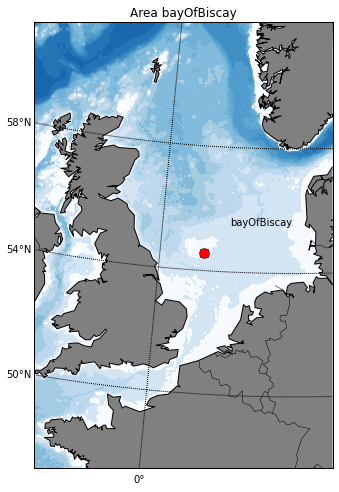

NameError: name 'etopo1' is not defined

In [7]:

makeMap(lon_start[i],lon_end[i],lat_start[i],lat_end[i],names[i],stationlonlist[i],stationlatlist[i])


